In [232]:
def example_downforce_curve(speed, coef_low_speed=1, coef_medium_speed=1, coef_high_speed=1):
    a = (coef_high_speed * 0.09)
    b = (coef_medium_speed * 2.5)
    c = (coef_low_speed * 5)
    return max(0, a * speed * speed + b * speed + c)

def example_drag_curve(speed):
    a = 0.08
    b = 2
    c = 0
    return max(0, a * speed * speed + b * speed + c)


class Front_wing:
    def __init__(self, downforce_curve, drag_curve):
        self.downforce_curve = downforce_curve
        self.drag_curve = drag_curve
    
    def downforce(self, speed):
        return self.downforce_curve(speed)

    def drag(self, speed):
        return self.drag_curve(speed)
    
f_w = Front_wing(example_downforce_curve, example_drag_curve)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Aeorynamic curves'}, xlabel='Speed (km/h)', ylabel='Forces (Nm)'>)

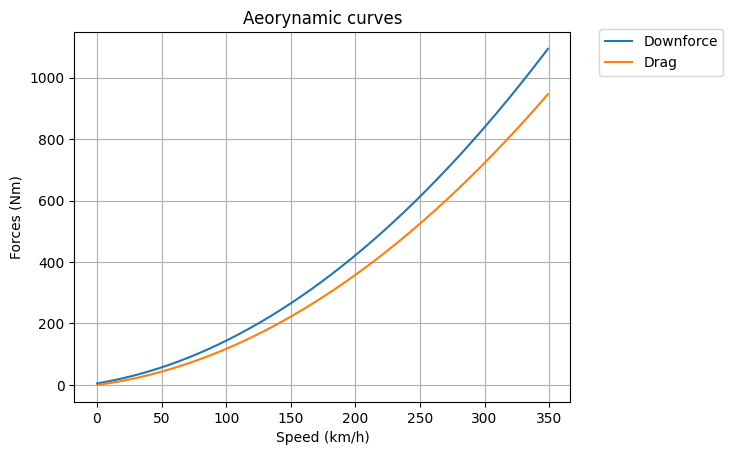

In [233]:
def plot_downforce_curve(wing):
    import numpy as np
    import matplotlib.pyplot as plt
    from sim_core.utils import kph_to_ms

    speeds = np.arange(0, 350)
    downforce_values = [wing.downforce(kph_to_ms(speed)) for speed in speeds]
    drag_values = [wing.drag(kph_to_ms(speed)) for speed in speeds]

    fig, ax = plt.subplots()
    ax.plot(speeds, downforce_values, label="Downforce")
    ax.plot(speeds, drag_values, label="Drag")
    ax.grid()
    ax.set_title('Aeorynamic curves')
    ax.set_xlabel('Speed (km/h)')
    ax.set_ylabel('Forces (Nm)')
    fig.legend(bbox_to_anchor=(1.15, 0.9))
    return fig, ax

plot_downforce_curve(f_w)

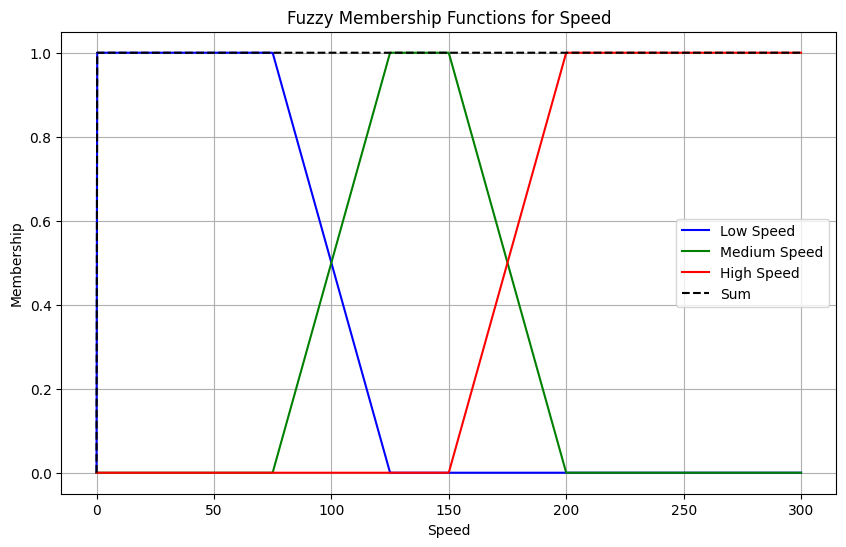

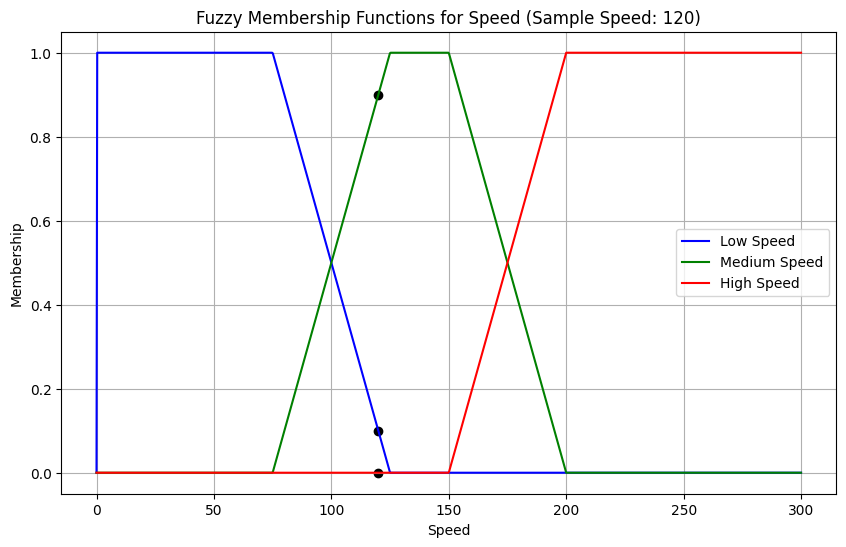

(0.1, 0.9, 0)

In [234]:
import numpy as np
import matplotlib.pyplot as plt
from sim_core.utils import low_speed, medium_speed, high_speed, speed_membership

# Test functions
x_values = np.linspace(0, 300, 1000)
low_values = [low_speed(x) for x in x_values]
medium_values = [medium_speed(x) for x in x_values]
high_values = [high_speed(x) for x in x_values]

sum_values = np.array(low_values) + np.array(medium_values) + np.array(high_values)

plt.figure(figsize=(10, 6))
plt.plot(x_values, low_values, label='Low Speed', color='blue')
plt.plot(x_values, medium_values, label='Medium Speed', color='green')
plt.plot(x_values, high_values, label='High Speed', color='red')
plt.plot(x_values, sum_values, label='Sum', color='black', linestyle='--')
plt.title('Fuzzy Membership Functions for Speed')
plt.xlabel('Speed')
plt.ylabel('Membership')
plt.legend()
plt.grid(True)
plt.show()

# Test with a sample speed
sample_speed = 120
low_membership, medium_membership, high_membership = speed_membership(sample_speed)

# Plot the membership functions along with the sample speed membership
plt.figure(figsize=(10, 6))
plt.plot(x_values, low_values, label='Low Speed', color='blue')
plt.plot(x_values, medium_values, label='Medium Speed', color='green')
plt.plot(x_values, high_values, label='High Speed', color='red')
plt.scatter([sample_speed, sample_speed, sample_speed], [low_membership, medium_membership, high_membership], color='black', marker='o')
plt.title(f'Fuzzy Membership Functions for Speed (Sample Speed: {sample_speed})')
plt.xlabel('Speed')
plt.ylabel('Membership')
plt.legend()
plt.grid(True)
plt.show()

(low_membership, medium_membership, high_membership)

In [235]:
from typing import Callable

class AerodynamicProfile:
    def __init__(self, baseline: Callable[[float], float], coef_low_speed: float = 1, coef_medium_speed: float = 1, coef_high_speed: float = 1):
        self.baseline = baseline
        self.coef_low_speed = coef_low_speed
        self.coef_medium_speed = coef_medium_speed
        self.coef_high_speed = coef_high_speed
    
    def output(self, speed):
        from sim_core.utils import kph_to_ms
        low_membership, medium_membership, high_membership = speed_membership(speed)
        out = self.baseline(kph_to_ms(speed))
        return out * self.coef_low_speed * low_membership + out * self.coef_medium_speed * medium_membership + out * self.coef_high_speed * high_membership

In [241]:
class FrontWing:
    class AerodynamicComponent:
        def __init__(self, downforce: AerodynamicProfile, drag: AerodynamicProfile, base_weight: float, coef_weight: float = 1):
            self.downforce = downforce
            self.drag = drag
            self.base_weight = base_weight
            self.coef_weight = coef_weight

        def get_downforce(self, speed: float):
            return self.downforce.output(speed)
        
        def get_drag(self, speed: float):
            return self.drag.output(speed)
    
    class MainPlane(AerodynamicComponent):
        def __init__(self, downforce: AerodynamicProfile, drag: AerodynamicProfile, base_weight: float, coef_weight: float = 1):
            super().__init__(downforce, drag, base_weight, coef_weight)
    
    class Flap(AerodynamicComponent):
        stall_angle: float = 40
        def __init__(self, downforce: AerodynamicProfile, drag: AerodynamicProfile, base_weight: float, coef_weight: float = 1, angle_range: tuple = (0, 60)):
            super().__init__(downforce, drag, base_weight, coef_weight)
            self.angle_range = angle_range
            self.angle = angle_range[0]
        def set_angle(self, angle: float):
            if angle < self.angle_range[0] or angle > self.angle_range[1]:
                raise Exception(f"Angle must be between {self.angle_range[0]} and {self.angle_range[1]}")
            self.angle = angle
        def get_downforce(self, speed: float):
            if self.angle <= self.stall_angle:
                return super().get_downforce(speed) * (self.angle + 5) / self.angle_range[-1]
            else:
                return super().get_downforce(speed) * (self.stall_angle - 1.5 * (self.angle + 5 - self.stall_angle)) / self.angle_range[-1]
        def get_drag(self, speed: float):
            return super().get_drag(speed) * (self.angle + 5) / self.angle_range[-1]
    
    class EndPlate(AerodynamicComponent):
        def __init__(self, downforce: AerodynamicProfile, drag: AerodynamicProfile, drag_reduction_percent: float, tire_wear_reduction_percent: float, tire_temp_reduction_percent: float, base_weight: float, coef_weight: float = 1):
            super().__init__(downforce, drag, base_weight, coef_weight)
            self.drag_reduction_percent = drag_reduction_percent
            self.tire_wear_reduction_percent = tire_wear_reduction_percent
            self.tire_temp_reduction_percent = tire_temp_reduction_percent

        def get_downforce(self, speed: float):
            return super().get_downforce(speed)
        
        def get_drag(self, speed: float):
            return super().get_drag(speed)

    def __init__(self, mainplane: MainPlane, flap: Flap, endplate: EndPlate):
        self.mainplane = mainplane
        self.flap = flap
        self.endplate = endplate
    
    def get_downforce(self, speed: float):
        return self.mainplane.get_downforce(speed) + self.flap.get_downforce(speed) + self.endplate.get_downforce(speed)
    
    def get_drag(self, speed: float):
        return (self.mainplane.get_drag(speed) + self.flap.get_drag(speed) + self.endplate.get_drag(speed)) * (1 - self.endplate.drag_reduction_percent)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Aeorynamic curves'}, xlabel='Speed (km/h)', ylabel='Forces (Nm)'>)

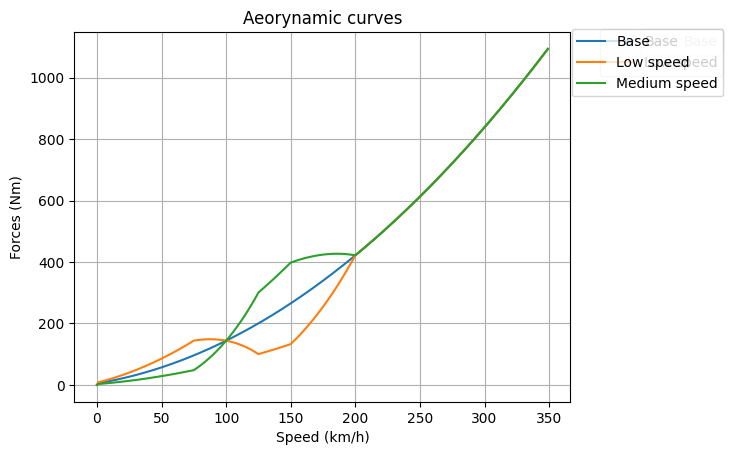

In [237]:
base_downforce_profile = AerodynamicProfile(example_downforce_curve)
low_speed_downforce__profile = AerodynamicProfile(example_downforce_curve, coef_low_speed=1.5, coef_medium_speed=0.5)
medium_speed_downforce_profile = AerodynamicProfile(example_downforce_curve, coef_low_speed=0.5, coef_medium_speed=1.5)

base_drag_profile = AerodynamicProfile(example_drag_curve)
low_speed_drag_profile = AerodynamicProfile(example_drag_curve, coef_low_speed=1.5, coef_medium_speed=0.5)
medium_speed_drag_profile = AerodynamicProfile(example_drag_curve, coef_low_speed=0.5, coef_medium_speed=1.5)

f_w = FrontWing(FrontWing.MainPlane(base_downforce_profile, base_drag_profile, 5))
f_w2 = FrontWing(FrontWing.MainPlane(low_speed_downforce__profile, low_speed_drag_profile, 5))
f_w3 = FrontWing(FrontWing.MainPlane(medium_speed_downforce_profile, medium_speed_drag_profile, 5))

def plot_downforce_curve(wing, fig_ax=None, label=None):
    import numpy as np
    import matplotlib.pyplot as plt
    from sim_core.utils import kph_to_ms

    speeds = np.arange(0, 350)
    downforce_values = [wing.get_downforce(speed) for speed in speeds]

    if fig_ax == None:
        fig, ax = plt.subplots()
    else:
        fig, ax = fig_ax
    if label is None:
        label = "Downforce"
    ax.plot(speeds, downforce_values, label=label)
    ax.grid()
    ax.set_title('Aeorynamic curves')
    ax.set_xlabel('Speed (km/h)')
    ax.set_ylabel('Forces (Nm)')
    fig.legend(bbox_to_anchor=(1.15, 0.9))
    return fig, ax

fig, ax = plot_downforce_curve(f_w, label="Base")
fig, ax = plot_downforce_curve(f_w2, (fig, ax), label="Low speed")
plot_downforce_curve(f_w3, (fig, ax), label="Medium speed")

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Downforce curves'}, xlabel='Speed (km/h)', ylabel='Forces (Nm)'>)

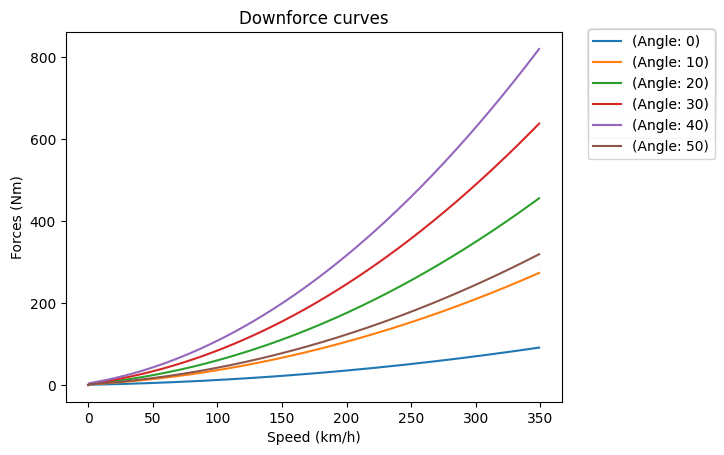

In [238]:
base_downforce_profile = AerodynamicProfile(example_downforce_curve)
base_drag_profile = AerodynamicProfile(example_drag_curve)
f_w = FrontWing.Flap(base_downforce_profile, base_drag_profile, 5)

def plot_downforce_curve(wing, fig_ax=None, label=None):
    import numpy as np
    import matplotlib.pyplot as plt
    from sim_core.utils import kph_to_ms

    speeds = np.arange(0, 350)
    downforce_values = [wing.get_downforce(speed) for speed in speeds]

    if fig_ax == None:
        fig, ax = plt.subplots()
    else:
        fig, ax = fig_ax
    if label is None:
        label = "Downforce"
    ax.plot(speeds, downforce_values, label=label)
    ax.grid()
    ax.set_title('Downforce curves')
    ax.set_xlabel('Speed (km/h)')
    ax.set_ylabel('Forces (Nm)')
    fig.legend(bbox_to_anchor=(1.15, 0.9))
    return fig, ax

fig, ax = plot_downforce_curve(f_w, label=f"(Angle: {f_w.angle})")
f_w.set_angle(10)
plot_downforce_curve(f_w, (fig, ax), label=f"(Angle: {f_w.angle})")
f_w.set_angle(20)
plot_downforce_curve(f_w, (fig, ax), label=f"(Angle: {f_w.angle})")
f_w.set_angle(30)
plot_downforce_curve(f_w, (fig, ax), label=f"(Angle: {f_w.angle})")
f_w.set_angle(40)
plot_downforce_curve(f_w, (fig, ax), label=f"(Angle: {f_w.angle})")
f_w.set_angle(50)
plot_downforce_curve(f_w, (fig, ax), label=f"(Angle: {f_w.angle})")

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Drag curves'}, xlabel='Speed (km/h)', ylabel='Forces (Nm)'>)

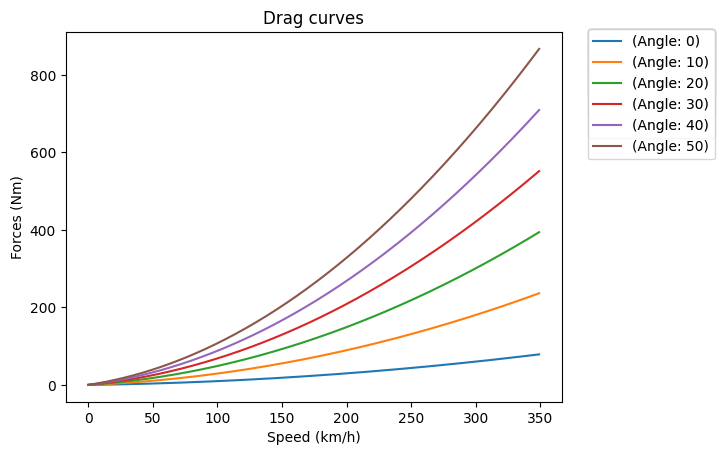

In [239]:
base_downforce_profile = AerodynamicProfile(example_downforce_curve)
base_drag_profile = AerodynamicProfile(example_drag_curve)
f_w = FrontWing.Flap(base_downforce_profile, base_drag_profile, 5)

def plot_downforce_curve(wing, fig_ax=None, label=None):
    import numpy as np
    import matplotlib.pyplot as plt
    from sim_core.utils import kph_to_ms

    speeds = np.arange(0, 350)
    downforce_values = [wing.get_drag(speed) for speed in speeds]

    if fig_ax == None:
        fig, ax = plt.subplots()
    else:
        fig, ax = fig_ax
    if label is None:
        label = "Downforce"
    ax.plot(speeds, downforce_values, label=label)
    ax.grid()
    ax.set_title('Drag curves')
    ax.set_xlabel('Speed (km/h)')
    ax.set_ylabel('Forces (Nm)')
    fig.legend(bbox_to_anchor=(1.15, 0.9))
    return fig, ax

fig, ax = plot_downforce_curve(f_w, label=f"(Angle: {f_w.angle})")
f_w.set_angle(10)
plot_downforce_curve(f_w, (fig, ax), label=f"(Angle: {f_w.angle})")
f_w.set_angle(20)
plot_downforce_curve(f_w, (fig, ax), label=f"(Angle: {f_w.angle})")
f_w.set_angle(30)
plot_downforce_curve(f_w, (fig, ax), label=f"(Angle: {f_w.angle})")
f_w.set_angle(40)
plot_downforce_curve(f_w, (fig, ax), label=f"(Angle: {f_w.angle})")
f_w.set_angle(50)
plot_downforce_curve(f_w, (fig, ax), label=f"(Angle: {f_w.angle})")